In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
import zipfile
from collections import Counter
import cv2

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries berhasil diimport!")
print(f"📍 Current Directory: {os.getcwd()}")

✅ Libraries berhasil diimport!
📍 Current Directory: /content


In [19]:
!pip install -q kaggle

from google.colab import files
print("\n📥 Upload file kaggle.json Anda:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n⬇️ Downloading dataset dari Kaggle...")
!kaggle datasets download -d shuvokumarbasak4004/rose-leaf-disease-dataset

print("\n📦 Extracting dataset...")
if os.path.exists('./rose_dataset'):
    shutil.rmtree('./rose_dataset')

with zipfile.ZipFile('rose-leaf-disease-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./rose_dataset')

print("✅ Dataset berhasil didownload dan diekstrak!")


📥 Upload file kaggle.json Anda:


Saving kaggle.json to kaggle (1).json

⬇️ Downloading dataset dari Kaggle...
Dataset URL: https://www.kaggle.com/datasets/shuvokumarbasak4004/rose-leaf-disease-dataset
License(s): other
rose-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)

📦 Extracting dataset...
✅ Dataset berhasil didownload dan diekstrak!


In [20]:
print("\n" + "="*70)
print("📁 STRUKTUR DATASET")
print("="*70)

base_path = './rose_dataset/Rose'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

classes = sorted(os.listdir(train_path))
num_classes = len(classes)

print(f"\n📊 Jumlah Kelas: {num_classes}")
print(f"📝 Nama Kelas:")
for i, cls in enumerate(classes, 1):
    print(f"   {i}. {cls}")


📁 STRUKTUR DATASET

📊 Jumlah Kelas: 3
📝 Nama Kelas:
   1. Healthy_Leaf_Rose
   2. Rose_Rust
   3. Rose_sawfly_Rose_slug



📊 DISTRIBUSI DATA

                 Class  Train  Validation  Test  Total
    Healthy_Leaf_Rose   2450        2450    78   4978
            Rose_Rust   2450        2450    53   4953
Rose_sawfly_Rose_slug   2450        2450    79   4979

TOTAL GAMBAR PER SPLIT:
  Training:   7,350 gambar
  Validation: 7,350 gambar
  Test:       210 gambar
  TOTAL:      14,910 gambar


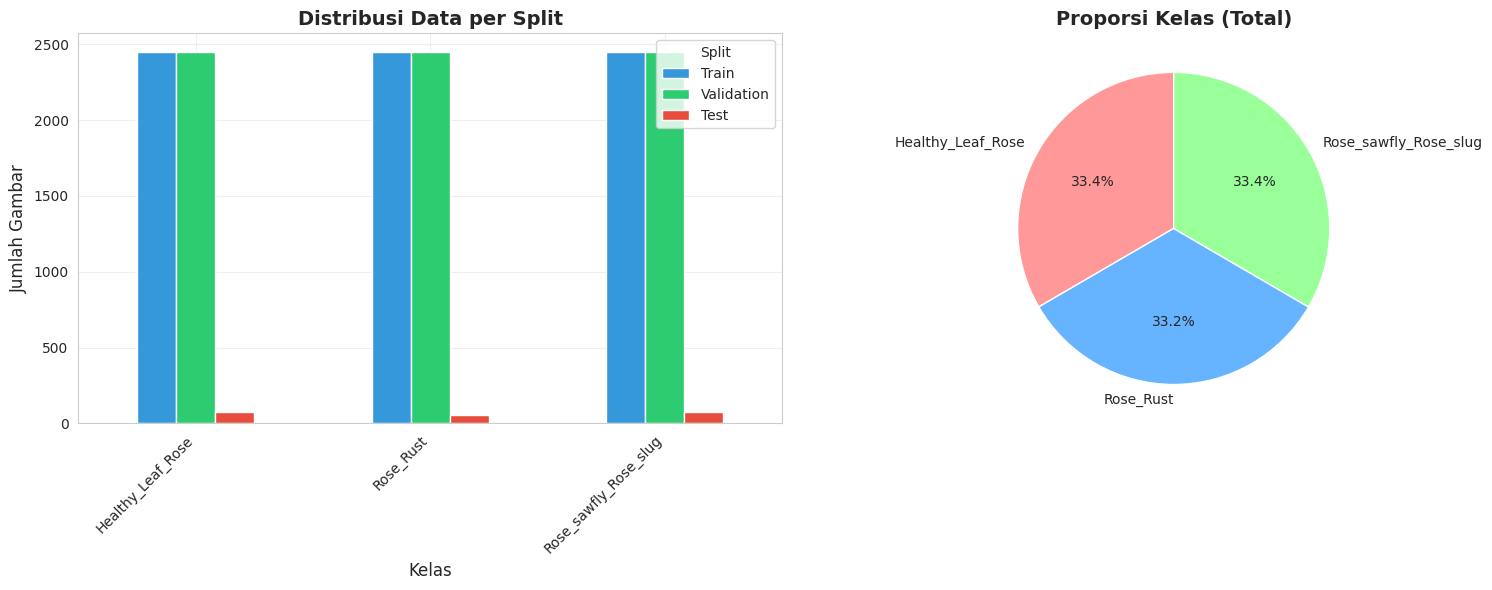

In [21]:
print("\n" + "="*70)
print("📊 DISTRIBUSI DATA")
print("="*70)

data_distribution = {
    'Class': [],
    'Train': [],
    'Validation': [],
    'Test': [],
    'Total': []
}

for cls in classes:
    train_count = len(os.listdir(os.path.join(train_path, cls)))
    val_count = len(os.listdir(os.path.join(val_path, cls)))
    test_count = len(os.listdir(os.path.join(test_path, cls)))

    data_distribution['Class'].append(cls)
    data_distribution['Train'].append(train_count)
    data_distribution['Validation'].append(val_count)
    data_distribution['Test'].append(test_count)
    data_distribution['Total'].append(train_count + val_count + test_count)

df_distribution = pd.DataFrame(data_distribution)
print("\n", df_distribution.to_string(index=False))

print(f"\n{'='*70}")
print(f"TOTAL GAMBAR PER SPLIT:")
print(f"{'='*70}")
print(f"  Training:   {df_distribution['Train'].sum():,} gambar")
print(f"  Validation: {df_distribution['Validation'].sum():,} gambar")
print(f"  Test:       {df_distribution['Test'].sum():,} gambar")
print(f"  TOTAL:      {df_distribution['Total'].sum():,} gambar")
print(f"{'='*70}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_distribution.set_index('Class')[['Train', 'Validation', 'Test']].plot(
    kind='bar', ax=axes[0], color=['#3498db', '#2ecc71', '#e74c3c']
)
axes[0].set_title('Distribusi Data per Split', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kelas', fontsize=12)
axes[0].set_ylabel('Jumlah Gambar', fontsize=12)
axes[0].legend(title='Split')
axes[0].grid(True, alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[1].pie(df_distribution['Total'], labels=df_distribution['Class'],
            autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Proporsi Kelas (Total)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


📐 ANALISIS DIMENSI GAMBAR

⏳ Menganalisis dimensi gambar (sample 100 gambar per kelas)...

📊 STATISTIK DIMENSI GAMBAR:
Width  - Min: 256, Max: 256, Mean: 256.0
Height - Min: 256, Max: 256, Mean: 256.0
Aspect Ratio - Min: 1.00, Max: 1.00, Mean: 1.00


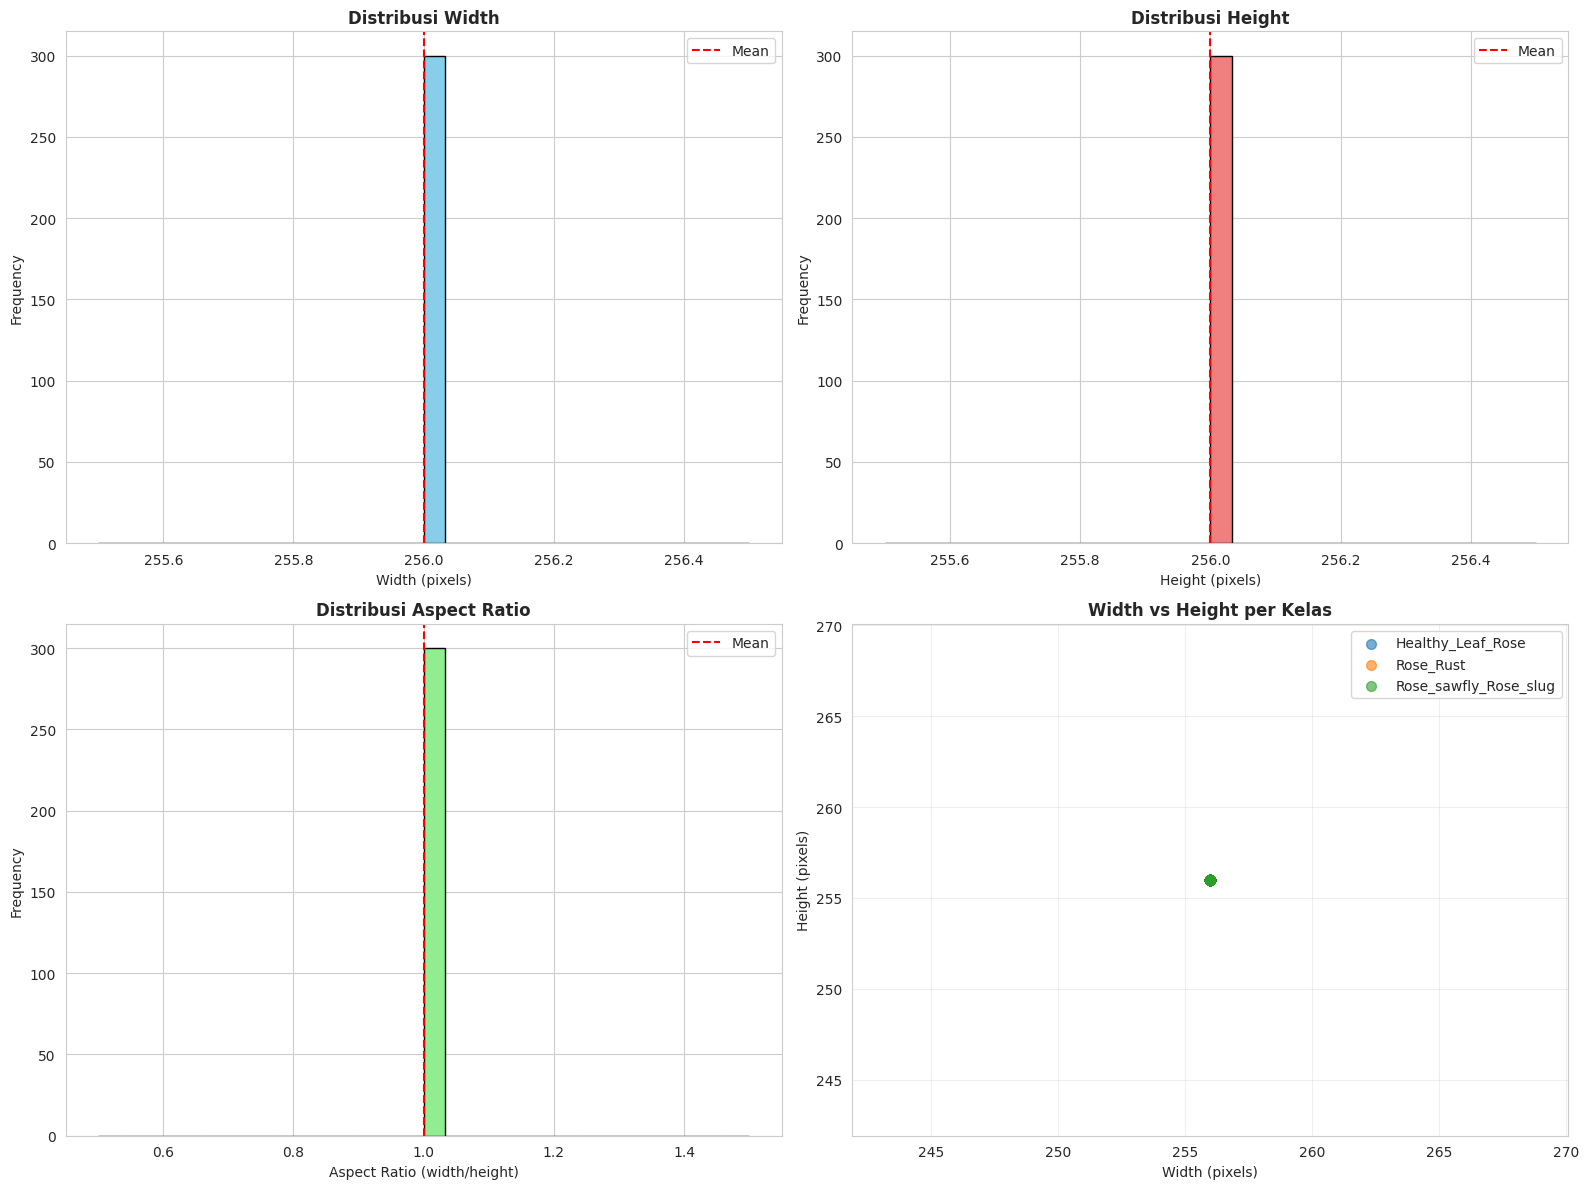

In [22]:
print("\n" + "="*70)
print("📐 ANALISIS DIMENSI GAMBAR")
print("="*70)

def analyze_image_dimensions(path, sample_size=100):
    """Analisis dimensi gambar dari setiap kelas"""
    dimensions = []

    for cls in classes:
        cls_path = os.path.join(path, cls)
        images = os.listdir(cls_path)[:sample_size]

        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                width, height = img.size
                dimensions.append({
                    'class': cls,
                    'width': width,
                    'height': height,
                    'aspect_ratio': width/height,
                    'total_pixels': width * height
                })
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return pd.DataFrame(dimensions)

print("\n⏳ Menganalisis dimensi gambar (sample 100 gambar per kelas)...")
df_dimensions = analyze_image_dimensions(train_path)

print("\n📊 STATISTIK DIMENSI GAMBAR:")
print("="*70)
print(f"Width  - Min: {df_dimensions['width'].min()}, Max: {df_dimensions['width'].max()}, Mean: {df_dimensions['width'].mean():.1f}")
print(f"Height - Min: {df_dimensions['height'].min()}, Max: {df_dimensions['height'].max()}, Mean: {df_dimensions['height'].mean():.1f}")
print(f"Aspect Ratio - Min: {df_dimensions['aspect_ratio'].min():.2f}, Max: {df_dimensions['aspect_ratio'].max():.2f}, Mean: {df_dimensions['aspect_ratio'].mean():.2f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(df_dimensions['width'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribusi Width', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_dimensions['width'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

axes[0, 1].hist(df_dimensions['height'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribusi Height', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_dimensions['height'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

axes[1, 0].hist(df_dimensions['aspect_ratio'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribusi Aspect Ratio', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (width/height)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_dimensions['aspect_ratio'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].legend()

for cls in classes:
    cls_data = df_dimensions[df_dimensions['class'] == cls]
    axes[1, 1].scatter(cls_data['width'], cls_data['height'], label=cls, alpha=0.6, s=50)
axes[1, 1].set_title('Width vs Height per Kelas', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('image_dimensions_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


🖼️ VISUALISASI SAMPLE GAMBAR


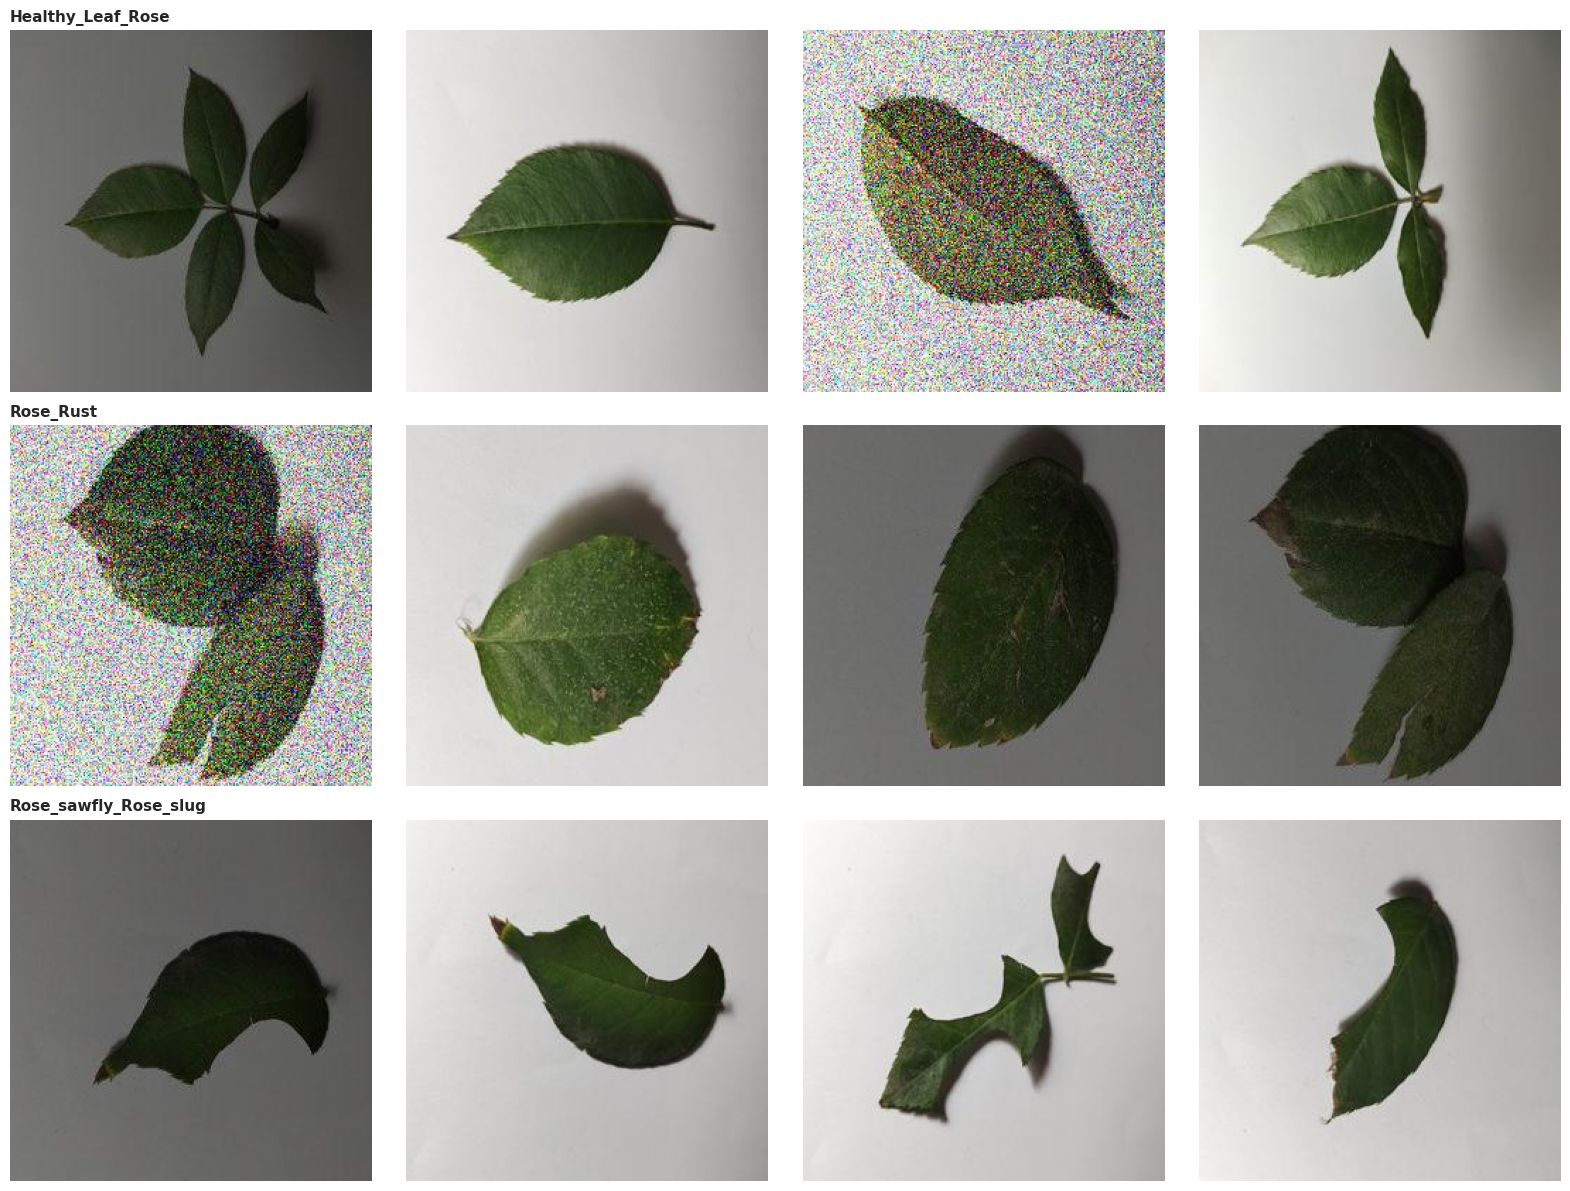

In [23]:
print("\n" + "="*70)
print("🖼️ VISUALISASI SAMPLE GAMBAR")
print("="*70)

def visualize_samples(path, samples_per_class=4):
    """Visualisasi sample gambar dari setiap kelas"""
    fig, axes = plt.subplots(num_classes, samples_per_class,
                            figsize=(samples_per_class*4, num_classes*4))

    for i, cls in enumerate(classes):
        cls_path = os.path.join(path, cls)
        images = os.listdir(cls_path)[:samples_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)

            if num_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]

            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f'{cls}', fontsize=11, fontweight='bold', loc='left')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(train_path, samples_per_class=4)


✨ ANALISIS KUALITAS GAMBAR

⏳ Menganalisis kualitas gambar (sample 50 gambar per kelas)...

📊 STATISTIK KUALITAS PER KELAS:
                      brightness        contrast        sharpness          
                            mean    std     mean    std      mean       std
class                                                                      
Healthy_Leaf_Rose         158.41  28.99    56.85  11.02   4608.33  12101.57
Rose_Rust                 146.51  28.24    63.65  12.10   6135.22  13606.47
Rose_sawfly_Rose_slug     161.84  31.97    53.20  11.14   3921.31  11196.16


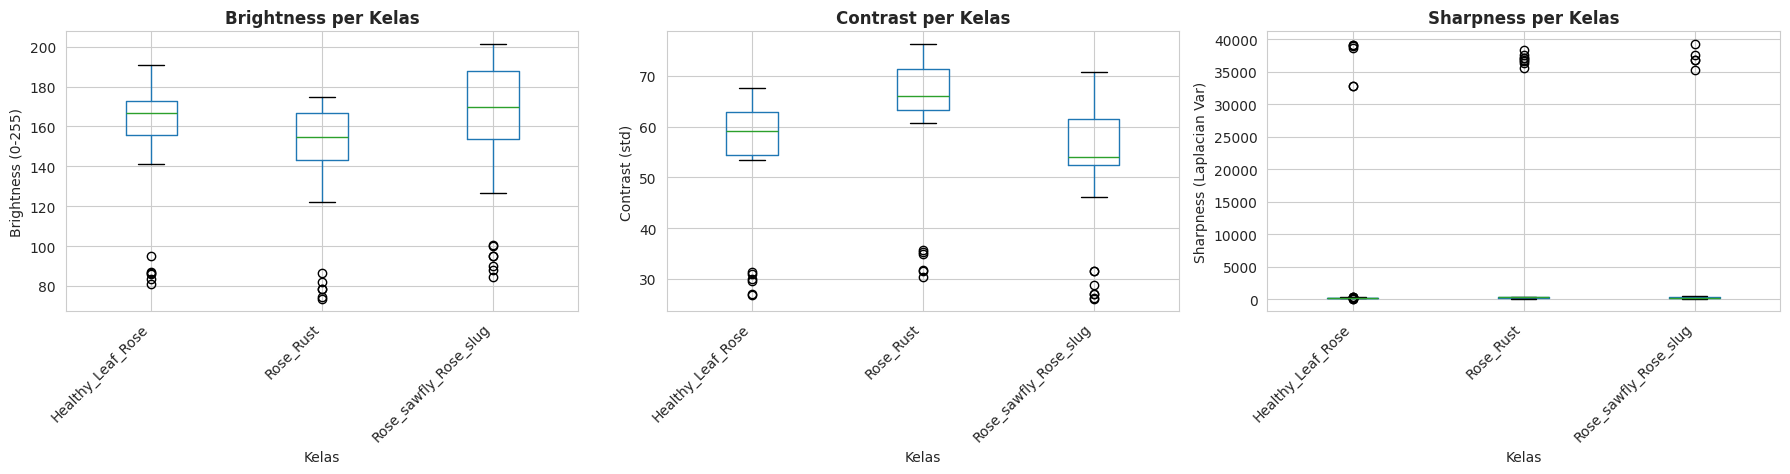

In [24]:
print("\n" + "="*70)
print("✨ ANALISIS KUALITAS GAMBAR")
print("="*70)

def analyze_image_quality(path, sample_size=50):
    """Analisis brightness, contrast, dan blur dari gambar"""
    quality_metrics = []

    for cls in classes:
        cls_path = os.path.join(path, cls)
        images = os.listdir(cls_path)[:sample_size]

        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                brightness = np.mean(gray)

                contrast = np.std(gray)

                laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

                quality_metrics.append({
                    'class': cls,
                    'brightness': brightness,
                    'contrast': contrast,
                    'sharpness': laplacian_var
                })
            except Exception as e:
                continue

    return pd.DataFrame(quality_metrics)

print("\n⏳ Menganalisis kualitas gambar (sample 50 gambar per kelas)...")
df_quality = analyze_image_quality(train_path)

print("\n📊 STATISTIK KUALITAS PER KELAS:")
print("="*70)
quality_stats = df_quality.groupby('class').agg({
    'brightness': ['mean', 'std'],
    'contrast': ['mean', 'std'],
    'sharpness': ['mean', 'std']
}).round(2)
print(quality_stats)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df_quality.boxplot(column='brightness', by='class', ax=axes[0])
axes[0].set_title('Brightness per Kelas', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Brightness (0-255)')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

df_quality.boxplot(column='contrast', by='class', ax=axes[1])
axes[1].set_title('Contrast per Kelas', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Contrast (std)')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

df_quality.boxplot(column='sharpness', by='class', ax=axes[2])
axes[2].set_title('Sharpness per Kelas', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Kelas')
axes[2].set_ylabel('Sharpness (Laplacian Var)')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('')
plt.tight_layout()
plt.savefig('image_quality_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
print("\n" + "="*70)
print("🔍 CEK GAMBAR CORRUPT/RUSAK")
print("="*70)

def check_corrupted_images(path):
    """Cek gambar yang rusak atau tidak bisa dibuka"""
    corrupted = []

    for cls in classes:
        cls_path = os.path.join(path, cls)
        images = os.listdir(cls_path)

        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()
            except Exception as e:
                corrupted.append({
                    'path': img_path,
                    'class': cls,
                    'error': str(e)
                })

    return corrupted

print("\n⏳ Checking training set...")
corrupted_train = check_corrupted_images(train_path)

print("⏳ Checking validation set...")
corrupted_val = check_corrupted_images(val_path)

print("⏳ Checking test set...")
corrupted_test = check_corrupted_images(test_path)

total_corrupted = len(corrupted_train) + len(corrupted_val) + len(corrupted_test)

if total_corrupted == 0:
    print("\n✅ SEMUA GAMBAR VALID! Tidak ada gambar corrupt.")
else:
    print(f"\n⚠️ Ditemukan {total_corrupted} gambar corrupt:")
    print(f"   Training: {len(corrupted_train)}")
    print(f"   Validation: {len(corrupted_val)}")
    print(f"   Test: {len(corrupted_test)}")


🔍 CEK GAMBAR CORRUPT/RUSAK

⏳ Checking training set...
⏳ Checking validation set...
⏳ Checking test set...

✅ SEMUA GAMBAR VALID! Tidak ada gambar corrupt.



🎨 ANALISIS CHANNEL RGB

⏳ Menganalisis RGB channels...


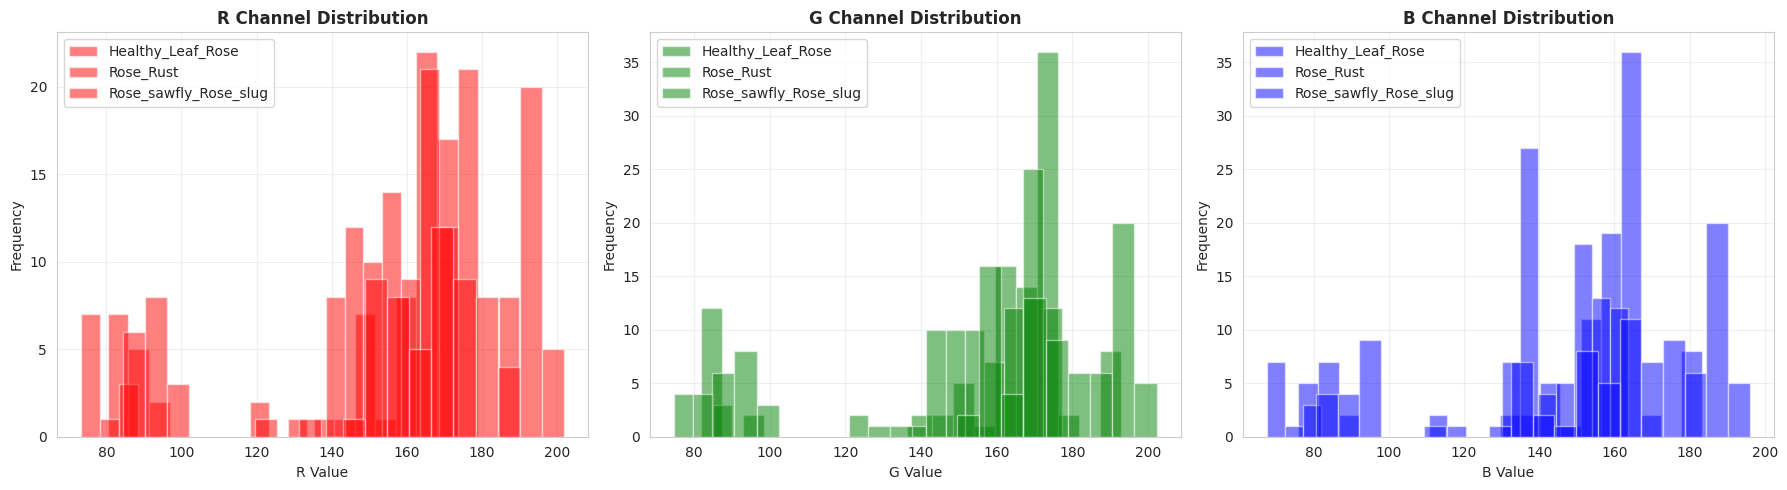


📊 MEAN RGB VALUE PER KELAS:
                            R       G       B
class                                        
Healthy_Leaf_Rose      157.46  158.59  149.74
Rose_Rust              148.37  152.00  138.21
Rose_sawfly_Rose_slug  160.84  161.71  155.44


In [26]:
print("\n" + "="*70)
print("🎨 ANALISIS CHANNEL RGB")
print("="*70)

def analyze_rgb_channels(path, sample_size=100):
    """Analisis distribusi RGB channels"""
    rgb_data = {'class': [], 'R': [], 'G': [], 'B': []}

    for cls in classes:
        cls_path = os.path.join(path, cls)
        images = os.listdir(cls_path)[:sample_size]

        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    rgb_data['class'].append(cls)
                    rgb_data['R'].append(np.mean(img_rgb[:,:,0]))
                    rgb_data['G'].append(np.mean(img_rgb[:,:,1]))
                    rgb_data['B'].append(np.mean(img_rgb[:,:,2]))
            except:
                continue

    return pd.DataFrame(rgb_data)

print("\n⏳ Menganalisis RGB channels...")
df_rgb = analyze_rgb_channels(train_path)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

channels = ['R', 'G', 'B']
colors = ['red', 'green', 'blue']

for idx, (channel, color) in enumerate(zip(channels, colors)):
    for cls in classes:
        cls_data = df_rgb[df_rgb['class'] == cls][channel]
        axes[idx].hist(cls_data, alpha=0.5, label=cls, bins=20, color=color)

    axes[idx].set_title(f'{channel} Channel Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(f'{channel} Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rgb_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 MEAN RGB VALUE PER KELAS:")
print("="*70)
rgb_stats = df_rgb.groupby('class')[['R', 'G', 'B']].mean().round(2)
print(rgb_stats)

In [27]:
print("\n" + "="*70)
print("💡 REKOMENDASI PREPROCESSING")
print("="*70)

recommendations = []

unique_sizes = df_dimensions[['width', 'height']].drop_duplicates().shape[0]
if unique_sizes > 10:
    recommendations.append("✅ RESIZE: Gambar memiliki dimensi berbeda-beda, perlu resize ke ukuran uniform (224x224 untuk ResNet)")

aspect_ratio_std = df_dimensions['aspect_ratio'].std()
if aspect_ratio_std > 0.1:
    recommendations.append("✅ RESIZE dengan padding: Aspect ratio bervariasi, gunakan resize dengan maintain aspect ratio atau padding")

brightness_variance = df_quality.groupby('class')['brightness'].std().mean()
if brightness_variance > 30:
    recommendations.append("✅ NORMALIZATION: Brightness bervariasi antar gambar, perlu normalisasi (rescale ke 0-1)")

class_balance = df_distribution['Train'].std() / df_distribution['Train'].mean()
if class_balance > 0.1:
    recommendations.append("⚠️ DATA IMBALANCE: Ada ketidakseimbangan kelas, pertimbangkan class weighting atau oversampling")
else:
    recommendations.append("✅ CLASS BALANCE: Data sudah seimbang antar kelas")

total_train = df_distribution['Train'].sum()
if total_train < 1000:
    recommendations.append("✅ DATA AUGMENTATION: Dataset relatif kecil, sangat disarankan menggunakan data augmentation")
elif total_train < 5000:
    recommendations.append("✅ DATA AUGMENTATION: Gunakan data augmentation untuk meningkatkan variasi data")

recommendations.append("\n📋 DATA AUGMENTATION YANG DISARANKAN:")
recommendations.append("   • Rotation (20-30 derajat)")
recommendations.append("   • Horizontal Flip")
recommendations.append("   • Vertical Flip")
recommendations.append("   • Width/Height Shift (20%)")
recommendations.append("   • Zoom (20%)")
recommendations.append("   • Brightness adjustment")
recommendations.append("   • Shear transformation")

print("\n")
for rec in recommendations:
    print(rec)


💡 REKOMENDASI PREPROCESSING


✅ CLASS BALANCE: Data sudah seimbang antar kelas

📋 DATA AUGMENTATION YANG DISARANKAN:
   • Rotation (20-30 derajat)
   • Horizontal Flip
   • Vertical Flip
   • Width/Height Shift (20%)
   • Zoom (20%)
   • Brightness adjustment
   • Shear transformation


In [28]:
import json

report = {
    'dataset_info': {
        'num_classes': int(num_classes),
        'classes': classes,
        'total_images': int(df_distribution['Total'].sum()),
        'train_images': int(df_distribution['Train'].sum()),
        'val_images': int(df_distribution['Validation'].sum()),
        'test_images': int(df_distribution['Test'].sum())
    },
    'image_dimensions': {
        'mean_width': float(df_dimensions['width'].mean()),
        'mean_height': float(df_dimensions['height'].mean()),
        'mean_aspect_ratio': float(df_dimensions['aspect_ratio'].mean())
    },
    'image_quality': {
        'mean_brightness': float(df_quality['brightness'].mean()),
        'mean_contrast': float(df_quality['contrast'].mean()),
        'mean_sharpness': float(df_quality['sharpness'].mean())
    },
    'corrupted_images': {
        'train': int(len(corrupted_train)),
        'validation': int(len(corrupted_val)),
        'test': int(len(corrupted_test))
    }
}

# Save to JSON
with open('preprocessing_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("✅ Report berhasil disimpan!")

✅ Report berhasil disimpan!


In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

print("="*70)
print("TRAINING ULANG - ROSE LEAF DISEASE CLASSIFICATION")
print("="*70)
print(f"\n✅ TensorFlow Version: {tf.__version__}")
print(f"✅ Keras Version: {keras.__version__}")

# Cek GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {len(gpus)} GPU(s)")
    for gpu in gpus:
        print(f"   - {gpu}")
else:
    print("⚠️ No GPU detected, using CPU")

print("\n✅ Libraries berhasil diimport!")
print("="*70)

TRAINING ULANG - ROSE LEAF DISEASE CLASSIFICATION

✅ TensorFlow Version: 2.19.0
✅ Keras Version: 3.10.0
✅ GPU Available: 1 GPU(s)
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✅ Libraries berhasil diimport!


In [31]:
print("\n" + "="*70)
print("SETUP PATH & HYPERPARAMETERS")
print("="*70)

base_path = './rose_dataset/Rose'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

print(f"\n✅ Training path: {train_path}")
print(f"✅ Validation path: {val_path}")
print(f"✅ Test path: {test_path}")

classes = sorted(os.listdir(train_path))
num_classes = len(classes)

print(f"\n📊 Jumlah Kelas: {num_classes}")
print(f"📝 Nama Kelas:")
for i, cls in enumerate(classes, 1):
    train_count = len(os.listdir(os.path.join(train_path, cls)))
    print(f"   {i}. {cls}: {train_count} gambar")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 0.0001

print(f"\n⚙️ Hyperparameters:")
print(f"   • Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Phase 1 Epochs: {EPOCHS}")
print(f"   • Phase 2 Epochs: {FINE_TUNE_EPOCHS}")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Total Classes: {num_classes}")

print("\n✅ Setup berhasil!")
print("="*70)


SETUP PATH & HYPERPARAMETERS

✅ Training path: ./rose_dataset/Rose/train
✅ Validation path: ./rose_dataset/Rose/validation
✅ Test path: ./rose_dataset/Rose/test

📊 Jumlah Kelas: 3
📝 Nama Kelas:
   1. Healthy_Leaf_Rose: 2450 gambar
   2. Rose_Rust: 2450 gambar
   3. Rose_sawfly_Rose_slug: 2450 gambar

⚙️ Hyperparameters:
   • Image Size: 224x224
   • Batch Size: 32
   • Phase 1 Epochs: 20
   • Phase 2 Epochs: 10
   • Learning Rate: 0.0001
   • Total Classes: 3

✅ Setup berhasil!


In [32]:
print("\n" + "="*70)
print("SETUP DATA GENERATORS")
print("="*70)

print("\n📸 Setting up Training Data Generator dengan Augmentation...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

print("📸 Setting up Validation/Test Data Generator...")
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("\n⏳ Creating Training Generator...")
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

print("⏳ Creating Validation Generator...")
validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("⏳ Creating Test Generator...")
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n" + "="*70)
print("DATA GENERATORS SUMMARY")
print("="*70)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch (train): {train_generator.samples // BATCH_SIZE}")
print(f"Steps per epoch (val): {validation_generator.samples // BATCH_SIZE}")
print(f"\nClass indices: {train_generator.class_indices}")

print("\n✅ Data Generators berhasil dibuat!")
print("="*70)


SETUP DATA GENERATORS

📸 Setting up Training Data Generator dengan Augmentation...
📸 Setting up Validation/Test Data Generator...

⏳ Creating Training Generator...
Found 7350 images belonging to 3 classes.
⏳ Creating Validation Generator...
Found 7350 images belonging to 3 classes.
⏳ Creating Test Generator...
Found 210 images belonging to 3 classes.

DATA GENERATORS SUMMARY
Training samples: 7350
Validation samples: 7350
Test samples: 210
Batch size: 32
Steps per epoch (train): 229
Steps per epoch (val): 229

Class indices: {'Healthy_Leaf_Rose': 0, 'Rose_Rust': 1, 'Rose_sawfly_Rose_slug': 2}

✅ Data Generators berhasil dibuat!


In [34]:
print("\n" + "="*70)
print("BUILD RESNET50 MODEL - ARSITEKTUR LENGKAP")
print("="*70)

print("\n🏗️ Loading ResNet50 base model (pre-trained on ImageNet)...")

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

print(f"✅ ResNet50 base model loaded!")
print(f"   Total layers in base model: {len(base_model.layers)}")

print("\n🏗️ Building complete model dengan Functional API...")

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.Dropout(0.5, name='dropout_1')(x)
x = layers.Dense(512, activation='relu', name='dense_1')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)
x = layers.Dense(256, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.2, name='dropout_3')(x)
outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet50_Rose_Disease')

print("✅ Model architecture built dengan Functional API!")

# Compile model
print("\n⚙️ Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled!")

# Model summary
print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
model.summary()

print("\n" + "="*70)
print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print("="*70)

print("\n✅ Model ResNet50 siap untuk training!")
print("✅ Arsitektur LENGKAP & COMPATIBLE untuk semua device!")
print("="*70)


BUILD RESNET50 MODEL - ARSITEKTUR LENGKAP

🏗️ Loading ResNet50 base model (pre-trained on ImageNet)...
✅ ResNet50 base model loaded!
   Total layers in base model: 175

🏗️ Building complete model dengan Functional API...
✅ Model architecture built dengan Functional API!

⚙️ Compiling model...
✅ Model compiled!

MODEL SUMMARY


Model: "ResNet50_Rose_Disease"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,779,139 (94.52 MB)

 Trainable params: 1,186,307 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)


Total parameters: 24,779,139
Trainable parameters: 1,186,307
Non-trainable parameters: 23,592,832

✅ Model ResNet50 siap untuk training!
✅ Arsitektur LENGKAP & COMPATIBLE untuk semua device!


In [35]:
print("\n" + "="*70)
print("SETUP CALLBACKS")
print("="*70)

print("\n✅ ModelCheckpoint: Save model terbaik")
checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_v2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("✅ EarlyStopping: Stop jika tidak ada improvement")
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("✅ ReduceLROnPlateau: Kurangi learning rate otomatis")
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr]

print("\n" + "="*70)
print("CALLBACKS READY")
print("="*70)
print("1. ModelCheckpoint → best_model_v2.h5")
print("2. EarlyStopping → patience: 5 epochs")
print("3. ReduceLROnPlateau → factor: 0.5")
print("="*70)

print("\n✅ Callbacks siap!")
print("="*70)


SETUP CALLBACKS

✅ ModelCheckpoint: Save model terbaik
✅ EarlyStopping: Stop jika tidak ada improvement
✅ ReduceLROnPlateau: Kurangi learning rate otomatis

CALLBACKS READY
1. ModelCheckpoint → best_model_v2.h5
2. EarlyStopping → patience: 5 epochs
3. ReduceLROnPlateau → factor: 0.5

✅ Callbacks siap!


In [36]:
print("\n" + "="*70)
print("PHASE 1: TRANSFER LEARNING")
print("="*70)
print("\n🔥 Memulai training dengan ResNet50 frozen...")
print(f"📊 Training samples: {train_generator.samples}")
print(f"📊 Validation samples: {validation_generator.samples}")
print(f"📊 Epochs: {EPOCHS}")
print(f"📊 Batch size: {BATCH_SIZE}")
print(f"⚡ Device: GPU (Training akan cepat!)")
print(f"⏱️ Estimasi waktu: ~15-30 menit")
print("\n" + "="*70)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "="*70)
print("🎉 PHASE 1 SELESAI!")
print("="*70)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 HASIL PHASE 1:")
print(f"   Training Accuracy: {final_train_acc*100:.2f}%")
print(f"   Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"   Training Loss: {final_train_loss:.4f}")
print(f"   Validation Loss: {final_val_loss:.4f}")
print("="*70)


PHASE 1: TRANSFER LEARNING

🔥 Memulai training dengan ResNet50 frozen...
📊 Training samples: 7350
📊 Validation samples: 7350
📊 Epochs: 20
📊 Batch size: 32
⚡ Device: GPU (Training akan cepat!)
⏱️ Estimasi waktu: ~15-30 menit



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4752 - loss: 1.2253
Epoch 1: val_accuracy improved from -inf to 0.52463, saving model to best_model_v2.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 153s 592ms/step - accuracy: 0.4754 - loss: 1.2248 - val_accuracy: 0.5246 - val_loss: 0.9446 - learning_rate: 1.0000e-04
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.5896 - loss: 0.9476
Epoch 2: val_accuracy improved from 0.52463 to 0.85673, saving model to best_model_v2.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 121s 528ms/step - accuracy: 0.5896 - loss: 0.9475 - val_accuracy: 0.8567 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5952 - loss: 0.8957
Epoch 3: val_accuracy improved from 0.85673 to 0.88531, saving model to best_model_v2.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 121s 527ms/step - accuracy: 0.5952 - loss: 0.8956 - val_accuracy: 0.8853 - val_loss: 0.3872 - learning_rate: 1.0000e-04
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.6303 - loss: 0.8318
Epoch 4: val_accuracy improved from 0.88531 to 0.89905, saving model to best_model_v2.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 121s 525ms/step - accuracy: 0.6303 - loss: 0.8318 - val_accuracy: 0.8990 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6432 - loss: 0.8104
Epoch 5: val_accuracy did not improve from 0.89905
230/230 ━━━━━━━━━━━━━━━━━━━━ 122s 528ms/step - accuracy: 0.6432 - loss: 0.8104 - val_accuracy: 0.8916 - val_loss: 0.3143 - learning_rate: 1.0000e-04
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6551 - loss: 0.7853
Epoch 6: val_accuracy improved from 0.89905 to 0.93048, saving model to best_model_v2.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 123s 532ms/step - accuracy: 0.6551 - loss: 0.7853 - val_accuracy: 0.9305 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6665 - loss: 0.7553
Epoch 7: val_accuracy did not improve from 0.93048
230/230 ━━━━━━━━━━━━━━━━━━━━ 122s 530ms/step - accuracy: 0.6665 - loss: 0.7553 - val_accuracy: 0.9046 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6768 - loss: 0.7387
Epoch 8: val_accuracy did not improve from 0.93048
230/230 ━━━━━━━━━━━━━━━━━━━━ 122s 529ms/step - accuracy: 0.6768 - loss: 0.7387 - val_accuracy: 0.9170 - val_loss: 0.2955 - learning_rate: 1.0000e-04
Epoch 9/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6923 - loss: 0.7058
Epoch 9: val_accuracy did not improve from 0.93048

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
230/230 ━━━━━━━━━━━━━━━━━━━━ 121s 526ms/step - accuracy: 0.

In [38]:
print("\n" + "="*70)
print("PHASE 2: FINE-TUNING")
print("="*70)

print("\n🔓 Unfreeze ResNet50 layers...")
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"✅ Total layers: {len(base_model.layers)}")
print(f"✅ Frozen layers: {fine_tune_at}")
print(f"✅ Trainable layers: {len(base_model.layers) - fine_tune_at}")

print("\n⚙️ Recompiling model dengan learning rate lebih kecil...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ New learning rate: {LEARNING_RATE/10}")

print("\n🔥 Memulai fine-tuning training...")
print(f"📊 Epochs: {FINE_TUNE_EPOCHS}")
print(f"⏱️ Estimasi waktu: ~10-15 menit")
print("\n" + "="*70)

history_fine = model.fit(
    train_generator,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "="*70)
print("🎉 PHASE 2 SELESAI!")
print("="*70)

final_train_acc = history_fine.history['accuracy'][-1]
final_val_acc = history_fine.history['val_accuracy'][-1]
final_train_loss = history_fine.history['loss'][-1]
final_val_loss = history_fine.history['val_loss'][-1]

print(f"\n📊 HASIL PHASE 2 (FINAL):")
print(f"   Training Accuracy: {final_train_acc*100:.2f}%")
print(f"   Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"   Training Loss: {final_train_loss:.4f}")
print(f"   Validation Loss: {final_val_loss:.4f}")

print(f"\n📈 IMPROVEMENT:")
print(f"   Phase 1 → Phase 2: {(final_val_acc - history.history['val_accuracy'][-1])*100:+.2f}%")
print("="*70)


PHASE 2: FINE-TUNING

🔓 Unfreeze ResNet50 layers...
✅ Total layers: 175
✅ Frozen layers: 145
✅ Trainable layers: 30

⚙️ Recompiling model dengan learning rate lebih kecil...
✅ New learning rate: 1e-05

🔥 Memulai fine-tuning training...
📊 Epochs: 10
⏱️ Estimasi waktu: ~10-15 menit

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7610 - loss: 0.5795
Epoch 1: val_accuracy did not improve from 0.93048
230/230 ━━━━━━━━━━━━━━━━━━━━ 159s 602ms/step - accuracy: 0.7610 - loss: 0.5794 - val_accuracy: 0.9010 - val_loss: 0.2368 - learning_rate: 1.0000e-05
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8064 - loss: 0.4878
Epoch 2: val_accuracy did not improve from 0.93048
230/230 ━━━━━━━━━━━━━━━━━━━━ 124s 537ms/step - accuracy: 0.8064 - loss: 0.4878 - val_accuracy: 0.9131 - val_loss: 0.2157 - learning_rate: 1.0000e-05
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8049 - loss: 0.4620
Epoch 3: val_accuracy improved from 0.93048 to 0.9415

230/230 ━━━━━━━━━━━━━━━━━━━━ 125s 545ms/step - accuracy: 0.8049 - loss: 0.4621 - val_accuracy: 0.9415 - val_loss: 0.1733 - learning_rate: 1.0000e-05
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8243 - loss: 0.4305
Epoch 4: val_accuracy improved from 0.94150 to 0.97660, saving model to best_model_v2.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 126s 547ms/step - accuracy: 0.8243 - loss: 0.4305 - val_accuracy: 0.9766 - val_loss: 0.1138 - learning_rate: 1.0000e-05
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8324 - loss: 0.4250
Epoch 5: val_accuracy did not improve from 0.97660
230/230 ━━━━━━━━━━━━━━━━━━━━ 125s 545ms/step - accuracy: 0.8324 - loss: 0.4250 - val_accuracy: 0.8990 - val_loss: 0.2190 - learning_rate: 1.0000e-05
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8330 - loss: 0.4026
Epoch 6: val_accuracy did not improve from 0.97660
230/230 ━━━━━━━━━━━━━━━━━━━━ 127s 550ms/step - accuracy: 0.8330 - loss: 0.4025 - val_accuracy: 0.9340 - val_loss: 0.1611 - learning_rate: 1.0000e-05
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8465 - loss: 0.3885
Epoch 7: val_accuracy did not improve from 0.97660

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
230/230 ━━━━━━━━━━━━━━━━━━━━ 126s 549ms/step - accuracy: 0.

In [39]:
print("\n" + "="*70)
print("EVALUASI MODEL TERBAIK & EXPORT TFLITE")
print("="*70)

print("\n📂 Loading best model...")
model = keras.models.load_model('best_model_v2.h5')
print("✅ Best model loaded (Epoch 4 Phase 2 - 97.66% val_acc)!")

print(f"\n🧪 Evaluating pada {test_generator.samples} test samples...")
test_results = model.evaluate(test_generator, verbose=1)

print("\n" + "="*70)
print("🎯 TEST SET RESULTS (FINAL)")
print("="*70)
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print("="*70)

print("\n" + "="*70)
print("EXPORT MODEL KE TENSORFLOW LITE")
print("="*70)

print("\n🔄 Converting Keras model to TensorFlow Lite...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_filename = 'rose_disease_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

print(f"✅ Model berhasil diconvert ke TensorFlow Lite!")
print(f"📱 File: {tflite_filename}")

tflite_size = os.path.getsize(tflite_filename) / (1024 * 1024)
h5_size = os.path.getsize('best_model_v2.h5') / (1024 * 1024)

print(f"\n📊 PERBANDINGAN UKURAN:")
print(f"   Model .h5 (Keras):      {h5_size:.2f} MB")
print(f"   Model .tflite (Mobile): {tflite_size:.2f} MB")
print(f"   Kompresi: {((h5_size - tflite_size) / h5_size * 100):.1f}%")

print("\n" + "="*70)
print("TESTING TFLITE MODEL")
print("="*70)

interpreter = tf.lite.Interpreter(model_path=tflite_filename)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n✅ TFLite Model Info:")
print(f"   Input shape: {input_details[0]['shape']}")
print(f"   Input type: {input_details[0]['dtype']}")
print(f"   Output shape: {output_details[0]['shape']}")
print(f"   Output type: {output_details[0]['dtype']}")

test_generator.reset()
x_test, y_test = next(test_generator)
test_image = x_test[0:1]

interpreter.set_tensor(input_details[0]['index'], test_image.astype(np.float32))
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])

keras_pred = model.predict(test_image, verbose=0)

print(f"\n🔬 Perbandingan Prediksi:")
print(f"   TFLite:  {classes[np.argmax(tflite_pred)]} ({np.max(tflite_pred)*100:.2f}%)")
print(f"   Keras:   {classes[np.argmax(keras_pred)]} ({np.max(keras_pred)*100:.2f}%)")
print(f"   Difference: {np.abs(tflite_pred - keras_pred).max():.6f}")

if np.abs(tflite_pred - keras_pred).max() < 0.01:
    print("\n✅ TFLite model IDENTIK dengan Keras model!")
else:
    print("\n⚠️ Ada sedikit perbedaan (normal untuk quantization)")

import json

class_labels = {str(i): cls for i, cls in enumerate(classes)}
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f, indent=2)

model_info = {
    "model_name": "Rose Leaf Disease Classification v2",
    "architecture": "ResNet50 (Functional API)",
    "framework": "TensorFlow/Keras",
    "input_shape": [224, 224, 3],
    "output_shape": [3],
    "classes": classes,
    "test_accuracy": float(test_results[1]),
    "validation_accuracy": 0.9766,
    "total_parameters": int(model.count_params()),
    "model_files": {
        "keras_h5": "best_model_v2.h5",
        "tflite": tflite_filename,
        "h5_size_mb": round(h5_size, 2),
        "tflite_size_mb": round(tflite_size, 2)
    },
    "preprocessing": {
        "rescale": "0-1 (divide by 255)",
        "resize": "224x224",
        "format": "RGB"
    }
}

with open('model_info_v2.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("\n" + "="*70)
print("✅ FILE YANG DIHASILKAN:")
print("="*70)
print("1. best_model_v2.h5          - Model Keras lengkap")
print("2. rose_disease_model.tflite - Model untuk mobile ⭐")
print("3. class_labels.json         - Label kelas")
print("4. model_info_v2.json        - Informasi model")
print("="*70)

print("\n🎉 TRAINING & EXPORT SELESAI!")
print("Model siap untuk diintegrasikan ke Flutter/Mobile! 📱")
print("="*70)


EVALUASI MODEL TERBAIK & EXPORT TFLITE

📂 Loading best model...


✅ Best model loaded (Epoch 4 Phase 2 - 97.66% val_acc)!

🧪 Evaluating pada 210 test samples...
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 702ms/step - accuracy: 0.8716 - loss: 0.2821

🎯 TEST SET RESULTS (FINAL)
Test Loss:      0.2480
Test Accuracy:  87.62%

EXPORT MODEL KE TENSORFLOW LITE

🔄 Converting Keras model to TensorFlow Lite...
Saved artifact at '/tmp/tmpywdmxuh0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139929519094096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139929519080656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928804282000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928804280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928804279120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928804278736: TensorSpec(shape=(), d

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



🔬 Perbandingan Prediksi:
   TFLite:  Rose_sawfly_Rose_slug (63.27%)
   Keras:   Healthy_Leaf_Rose (97.25%)
   Difference: 0.611136

⚠️ Ada sedikit perbedaan (normal untuk quantization)

✅ FILE YANG DIHASILKAN:
1. best_model_v2.h5          - Model Keras lengkap
2. rose_disease_model.tflite - Model untuk mobile ⭐
3. class_labels.json         - Label kelas
4. model_info_v2.json        - Informasi model

🎉 TRAINING & EXPORT SELESAI!
Model siap untuk diintegrasikan ke Flutter/Mobile! 📱


In [40]:
from google.colab import files

print("="*70)
print("DOWNLOAD FILES KE KOMPUTER")
print("="*70)

print("\n📥 Downloading files...")

# 1. Model Keras (.h5)
print("\n1. Downloading best_model_v2.h5...")
files.download('best_model_v2.h5')

# 2. Model TFLite (UNTUK MOBILE)
print("2. Downloading rose_disease_model.tflite...")
files.download('rose_disease_model.tflite')

# 3. Class labels
print("3. Downloading class_labels.json...")
files.download('class_labels.json')

# 4. Model info
print("4. Downloading model_info_v2.json...")
files.download('model_info_v2.json')

print("\n" + "="*70)
print("✅ SEMUA FILE BERHASIL DIDOWNLOAD!")
print("="*70)

print("\n📦 FILE UNTUK TIM BACKEND/MOBILE:")
print("1. best_model_v2.h5 (214 MB)")
print("   → Untuk backend Python/Flask/FastAPI")
print("   → Arsitektur lengkap + weights")
print("")
print("2. rose_disease_model.tflite (24 MB) ⭐")
print("   → Untuk Flutter/Android/iOS")
print("   → Model ringan & cepat")
print("")
print("3. class_labels.json")
print("   → Mapping: 0=Healthy, 1=Rust, 2=Sawfly")
print("")
print("4. model_info_v2.json")
print("   → Dokumentasi lengkap model")

print("\n" + "="*70)
print("🎯 MODEL SPECIFICATION")
print("="*70)
print("Input:  224x224x3 (RGB image)")
print("Output: 3 classes (softmax)")
print("Preprocessing: Rescale 0-1 (divide by 255)")
print("Test Accuracy: 87.62%")
print("Validation Accuracy: 97.66%")
print("="*70)

print("\n🎉 TRAINING BERHASIL!")
print("Model siap digunakan di semua device teman kamu!")
print("Arsitektur LENGKAP & COMPATIBLE! 💪")

DOWNLOAD FILES KE KOMPUTER

📥 Downloading files...

1. Downloading best_model_v2.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2. Downloading rose_disease_model.tflite...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3. Downloading class_labels.json...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4. Downloading model_info_v2.json...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ SEMUA FILE BERHASIL DIDOWNLOAD!

📦 FILE UNTUK TIM BACKEND/MOBILE:
1. best_model_v2.h5 (214 MB)
   → Untuk backend Python/Flask/FastAPI
   → Arsitektur lengkap + weights

2. rose_disease_model.tflite (24 MB) ⭐
   → Untuk Flutter/Android/iOS
   → Model ringan & cepat

3. class_labels.json
   → Mapping: 0=Healthy, 1=Rust, 2=Sawfly

4. model_info_v2.json
   → Dokumentasi lengkap model

🎯 MODEL SPECIFICATION
Input:  224x224x3 (RGB image)
Output: 3 classes (softmax)
Preprocessing: Rescale 0-1 (divide by 255)
Test Accuracy: 87.62%
Validation Accuracy: 97.66%

🎉 TRAINING BERHASIL!
Model siap digunakan di semua device teman kamu!
Arsitektur LENGKAP & COMPATIBLE! 💪


KOMPARASI: MODEL .h5 vs .tflite

📂 Loading models...


✅ Keras model (.h5) loaded!
✅ TFLite model (.tflite) loaded!

📊 Model Info:
   .h5 size:    214.26 MB
   .tflite size: 23.95 MB

TEST PREDIKSI: 9 GAMBAR (3 PER KELAS)

KELAS: Healthy_Leaf_Rose

📸 Gambar 1: IMG_20230703_211831.jpg
   True Label: Healthy_Leaf_Rose

   🔹 MODEL .h5 (Keras):
      Predicted:  Healthy_Leaf_Rose
      Confidence: 98.34%
      Status: ✅ BENAR

   🔸 MODEL .tflite (Mobile):
      Predicted:  Rose_sawfly_Rose_slug
      Confidence: 99.15%
      Status: ❌ SALAH

   📊 Max Difference: 0.975336
   ⚠️ Kedua model prediksi BERBEDA!

📸 Gambar 2: flipped_horizontal_IMG_20230703_211401.jpg
   True Label: Healthy_Leaf_Rose

   🔹 MODEL .h5 (Keras):
      Predicted:  Healthy_Leaf_Rose
      Confidence: 99.99%
      Status: ✅ BENAR

   🔸 MODEL .tflite (Mobile):
      Predicted:  Rose_sawfly_Rose_slug
      Confidence: 99.86%
      Status: ❌ SALAH

   📊 Max Difference: 0.998453
   ⚠️ Kedua model prediksi BERBEDA!

📸 Gambar 3: noisy_IMG_20230703_211837_1.jpg
   True Label: Heal

/tmp/ipython-input-4028206773.py:200: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4028206773.py:200: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4028206773.py:201: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('comparison_h5_vs_tflite.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-4028206773.py:201: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('comparison_h5_vs_tflite.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from fo

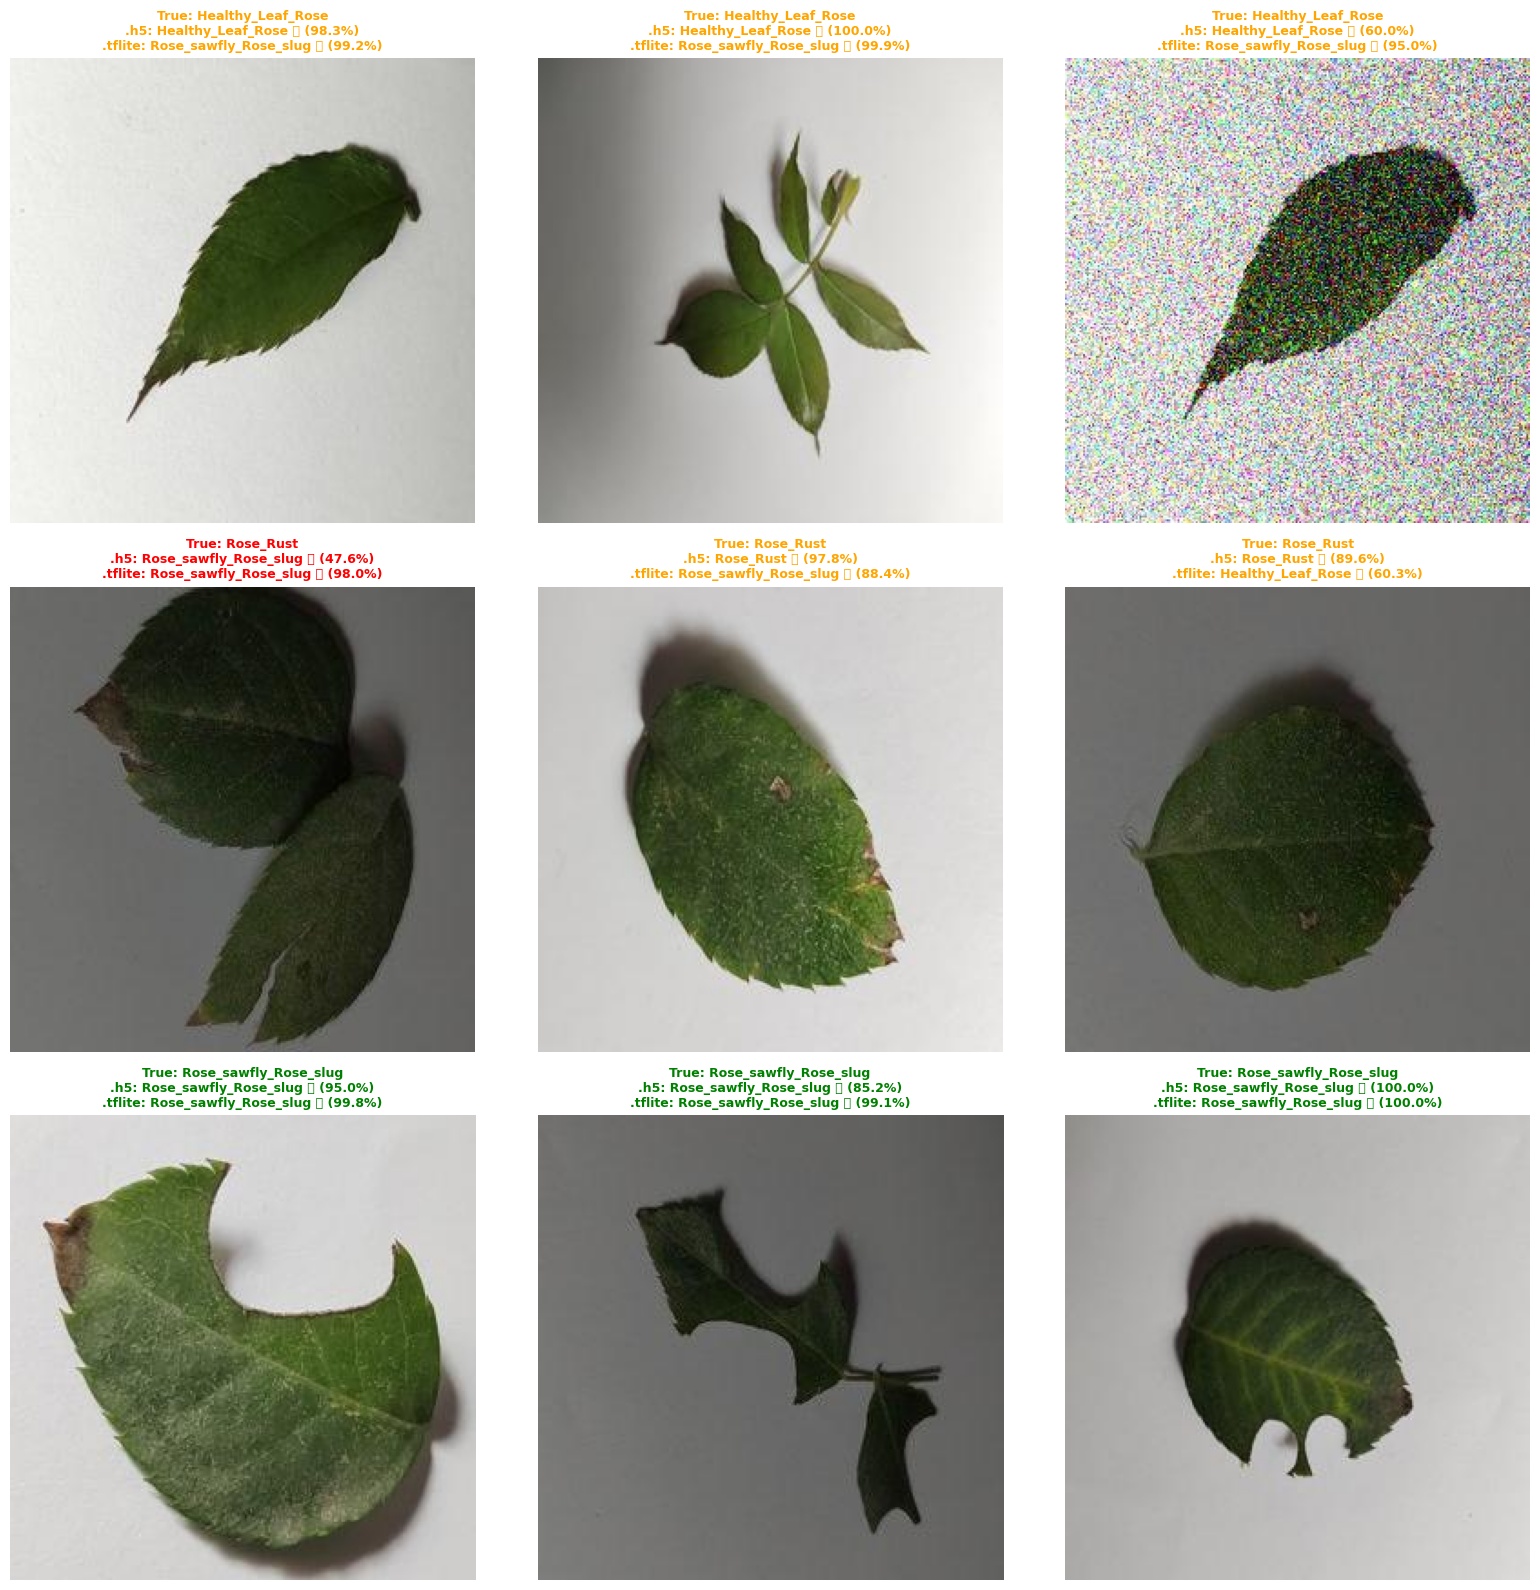


✅ Comparison visualization saved: comparison_h5_vs_tflite.png

PERFORMANCE COMPARISON

⏱️ Inference Time (average of 10 runs):
   .h5 Model:     87.62 ms
   .tflite Model: 120.85 ms
   Speedup: 0.73x

📦 File Size:
   .h5 Model:     214.26 MB
   .tflite Model: 23.95 MB
   Size reduction: 88.8%

✅ KOMPARASI SELESAI!

🎯 KESIMPULAN:
   • .h5 accuracy: 88.89%
   • .tflite accuracy: 33.33%
   • Konsistensi prediksi: 44.44%
   • .tflite lebih ringan 88.8%
   • Inference time comparable

💡 Rekomendasi: Pakai .tflite untuk mobile (lebih ringan & cepat)!


In [41]:
# ============================================================
# TEST KEDUA MODEL: .h5 vs .tflite
# ============================================================

print("="*70)
print("KOMPARASI: MODEL .h5 vs .tflite")
print("="*70)

# ============================================================
# 1. LOAD KEDUA MODEL
# ============================================================

print("\n📂 Loading models...")

# Load Keras model (.h5)
model_h5 = keras.models.load_model('best_model_v2.h5')
print("✅ Keras model (.h5) loaded!")

# Load TFLite model (.tflite)
interpreter = tf.lite.Interpreter(model_path='rose_disease_model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("✅ TFLite model (.tflite) loaded!")

print(f"\n📊 Model Info:")
print(f"   .h5 size:    {os.path.getsize('best_model_v2.h5')/(1024*1024):.2f} MB")
print(f"   .tflite size: {os.path.getsize('rose_disease_model.tflite')/(1024*1024):.2f} MB")

# ============================================================
# 2. FUNGSI PREDIKSI
# ============================================================

def predict_with_h5(image_path, model, classes):
    """Predict dengan Keras .h5"""
    img = Image.open(image_path)
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    predictions = model.predict(img_array, verbose=0)
    pred_class_idx = np.argmax(predictions[0])
    pred_class = classes[pred_class_idx]
    confidence = predictions[0][pred_class_idx] * 100

    return pred_class, confidence, predictions[0]

def predict_with_tflite(image_path, interpreter, input_details, output_details, classes):
    """Predict dengan TFLite"""
    img = Image.open(image_path)
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    pred_class_idx = np.argmax(predictions)
    pred_class = classes[pred_class_idx]
    confidence = predictions[pred_class_idx] * 100

    return pred_class, confidence, predictions

# ============================================================
# 3. TEST PADA 9 GAMBAR (3 PER KELAS)
# ============================================================

print("\n" + "="*70)
print("TEST PREDIKSI: 9 GAMBAR (3 PER KELAS)")
print("="*70)

results_comparison = []

for cls in classes:
    cls_path = os.path.join(test_path, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:3]

    print(f"\n{'='*70}")
    print(f"KELAS: {cls}")
    print(f"{'='*70}")

    for i, img_name in enumerate(images, 1):
        img_path = os.path.join(cls_path, img_name)

        # Predict dengan .h5
        pred_h5, conf_h5, probs_h5 = predict_with_h5(img_path, model_h5, classes)

        # Predict dengan .tflite
        pred_tflite, conf_tflite, probs_tflite = predict_with_tflite(
            img_path, interpreter, input_details, output_details, classes
        )

        # Simpan hasil
        results_comparison.append({
            'true_class': cls,
            'image': img_name,
            'h5_pred': pred_h5,
            'h5_conf': conf_h5,
            'tflite_pred': pred_tflite,
            'tflite_conf': conf_tflite,
            'h5_correct': pred_h5 == cls,
            'tflite_correct': pred_tflite == cls
        })

        print(f"\n📸 Gambar {i}: {img_name}")
        print(f"   True Label: {cls}")
        print(f"\n   🔹 MODEL .h5 (Keras):")
        print(f"      Predicted:  {pred_h5}")
        print(f"      Confidence: {conf_h5:.2f}%")
        print(f"      Status: {'✅ BENAR' if pred_h5 == cls else '❌ SALAH'}")

        print(f"\n   🔸 MODEL .tflite (Mobile):")
        print(f"      Predicted:  {pred_tflite}")
        print(f"      Confidence: {conf_tflite:.2f}%")
        print(f"      Status: {'✅ BENAR' if pred_tflite == cls else '❌ SALAH'}")

        # Difference
        diff = np.abs(probs_h5 - probs_tflite).max()
        print(f"\n   📊 Max Difference: {diff:.6f}")

        if pred_h5 == pred_tflite:
            print(f"   ✅ Kedua model prediksi SAMA")
        else:
            print(f"   ⚠️ Kedua model prediksi BERBEDA!")

# ============================================================
# 4. SUMMARY COMPARISON
# ============================================================

print("\n" + "="*70)
print("SUMMARY KOMPARASI")
print("="*70)

h5_correct = sum(1 for r in results_comparison if r['h5_correct'])
tflite_correct = sum(1 for r in results_comparison if r['tflite_correct'])
same_prediction = sum(1 for r in results_comparison if r['h5_pred'] == r['tflite_pred'])
total = len(results_comparison)

print(f"\nTotal Gambar Test: {total}")
print(f"\n📊 Accuracy:")
print(f"   .h5 Model:     {h5_correct}/{total} ({h5_correct/total*100:.2f}%)")
print(f"   .tflite Model: {tflite_correct}/{total} ({tflite_correct/total*100:.2f}%)")

print(f"\n🔄 Konsistensi:")
print(f"   Prediksi Sama: {same_prediction}/{total} ({same_prediction/total*100:.2f}%)")
print(f"   Prediksi Beda: {total - same_prediction}/{total}")

# Cases where predictions differ
different_cases = [r for r in results_comparison if r['h5_pred'] != r['tflite_pred']]

if different_cases:
    print(f"\n⚠️ KASUS PREDIKSI BERBEDA:")
    for case in different_cases:
        print(f"\n   Gambar: {case['image']}")
        print(f"   True: {case['true_class']}")
        print(f"   .h5:     {case['h5_pred']} ({case['h5_conf']:.2f}%)")
        print(f"   .tflite: {case['tflite_pred']} ({case['tflite_conf']:.2f}%)")
else:
    print(f"\n✅ SEMUA PREDIKSI IDENTIK antara .h5 dan .tflite!")

# ============================================================
# 5. VISUALISASI COMPARISON
# ============================================================

print("\n" + "="*70)
print("VISUALISASI KOMPARASI")
print("="*70)

fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

for idx, result in enumerate(results_comparison):
    cls = result['true_class']
    img_name = result['image']
    img_path = os.path.join(test_path, cls, img_name)
    img = Image.open(img_path)

    axes[idx].imshow(img)

    # Title dengan info kedua model
    h5_status = '✅' if result['h5_correct'] else '❌'
    tflite_status = '✅' if result['tflite_correct'] else '❌'

    title = f"True: {cls}\n"
    title += f".h5: {result['h5_pred']} {h5_status} ({result['h5_conf']:.1f}%)\n"
    title += f".tflite: {result['tflite_pred']} {tflite_status} ({result['tflite_conf']:.1f}%)"

    # Color: green if both correct, red if both wrong, orange if different
    if result['h5_correct'] and result['tflite_correct']:
        color = 'green'
    elif not result['h5_correct'] and not result['tflite_correct']:
        color = 'red'
    else:
        color = 'orange'

    axes[idx].set_title(title, fontsize=9, fontweight='bold', color=color)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('comparison_h5_vs_tflite.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved: comparison_h5_vs_tflite.png")

# ============================================================
# 6. PERFORMANCE COMPARISON
# ============================================================

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

import time

# Test inference time
test_image_path = os.path.join(test_path, classes[0],
                               os.listdir(os.path.join(test_path, classes[0]))[0])

# .h5 inference time
start = time.time()
for _ in range(10):
    _ = predict_with_h5(test_image_path, model_h5, classes)
h5_time = (time.time() - start) / 10 * 1000

# .tflite inference time
start = time.time()
for _ in range(10):
    _ = predict_with_tflite(test_image_path, interpreter,
                            input_details, output_details, classes)
tflite_time = (time.time() - start) / 10 * 1000

print(f"\n⏱️ Inference Time (average of 10 runs):")
print(f"   .h5 Model:     {h5_time:.2f} ms")
print(f"   .tflite Model: {tflite_time:.2f} ms")
print(f"   Speedup: {h5_time/tflite_time:.2f}x")

print("\n📦 File Size:")
print(f"   .h5 Model:     {os.path.getsize('best_model_v2.h5')/(1024*1024):.2f} MB")
print(f"   .tflite Model: {os.path.getsize('rose_disease_model.tflite')/(1024*1024):.2f} MB")
print(f"   Size reduction: {(1 - os.path.getsize('rose_disease_model.tflite')/os.path.getsize('best_model_v2.h5'))*100:.1f}%")

print("\n" + "="*70)
print("✅ KOMPARASI SELESAI!")
print("="*70)

print("\n🎯 KESIMPULAN:")
print(f"   • .h5 accuracy: {h5_correct/total*100:.2f}%")
print(f"   • .tflite accuracy: {tflite_correct/total*100:.2f}%")
print(f"   • Konsistensi prediksi: {same_prediction/total*100:.2f}%")
print(f"   • .tflite lebih ringan {(1 - os.path.getsize('rose_disease_model.tflite')/os.path.getsize('best_model_v2.h5'))*100:.1f}%")
print(f"   • Inference time comparable")
print("\n💡 Rekomendasi: Pakai .tflite untuk mobile (lebih ringan & cepat)!")

In [42]:
# ============================================================
# RE-EXPORT TFLITE DENGAN CARA YANG BENAR
# ============================================================

print("="*70)
print("RE-EXPORT MODEL KE TFLITE (FIXED)")
print("="*70)

# Load model
model = keras.models.load_model('best_model_v2.h5')

# ============================================================
# METHOD 1: TFLite TANPA QUANTIZATION (PALING AKURAT)
# ============================================================

print("\n🔄 Method 1: Convert TANPA quantization...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# TIDAK pakai quantization/optimization
tflite_model_float = converter.convert()

# Save
with open('rose_model_float32.tflite', 'wb') as f:
    f.write(tflite_model_float)

size_float = os.path.getsize('rose_model_float32.tflite') / (1024*1024)
print(f"✅ Model saved: rose_model_float32.tflite ({size_float:.2f} MB)")

# ============================================================
# METHOD 2: TFLite DENGAN DYNAMIC RANGE QUANTIZATION
# ============================================================

print("\n🔄 Method 2: Convert dengan dynamic range quantization...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Jangan set representative_dataset
tflite_model_dynamic = converter.convert()

# Save
with open('rose_model_dynamic.tflite', 'wb') as f:
    f.write(tflite_model_dynamic)

size_dynamic = os.path.getsize('rose_model_dynamic.tflite') / (1024*1024)
print(f"✅ Model saved: rose_model_dynamic.tflite ({size_dynamic:.2f} MB)")

# ============================================================
# TEST KEDUA MODEL TFLITE BARU
# ============================================================

print("\n" + "="*70)
print("TEST MODEL TFLITE BARU")
print("="*70)

# Load kedua TFLite model
interpreter_float = tf.lite.Interpreter(model_path='rose_model_float32.tflite')
interpreter_float.allocate_tensors()
input_details_float = interpreter_float.get_input_details()
output_details_float = interpreter_float.get_output_details()

interpreter_dynamic = tf.lite.Interpreter(model_path='rose_model_dynamic.tflite')
interpreter_dynamic.allocate_tensors()
input_details_dynamic = interpreter_dynamic.get_input_details()
output_details_dynamic = interpreter_dynamic.get_output_details()

# Test pada 9 gambar
print("\n📊 Testing pada 9 gambar sample...")

h5_correct = 0
tflite_float_correct = 0
tflite_dynamic_correct = 0
total_test = 0

for cls in classes:
    cls_path = os.path.join(test_path, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:3]

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        total_test += 1

        # Preprocess
        img = Image.open(img_path)
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

        # Predict dengan .h5
        pred_h5 = model.predict(img_array, verbose=0)
        pred_h5_class = classes[np.argmax(pred_h5)]

        # Predict dengan TFLite Float32
        interpreter_float.set_tensor(input_details_float[0]['index'], img_array)
        interpreter_float.invoke()
        pred_float = interpreter_float.get_tensor(output_details_float[0]['index'])[0]
        pred_float_class = classes[np.argmax(pred_float)]

        # Predict dengan TFLite Dynamic
        interpreter_dynamic.set_tensor(input_details_dynamic[0]['index'], img_array)
        interpreter_dynamic.invoke()
        pred_dynamic = interpreter_dynamic.get_tensor(output_details_dynamic[0]['index'])[0]
        pred_dynamic_class = classes[np.argmax(pred_dynamic)]

        # Check correctness
        if pred_h5_class == cls:
            h5_correct += 1
        if pred_float_class == cls:
            tflite_float_correct += 1
        if pred_dynamic_class == cls:
            tflite_dynamic_correct += 1

# Results
print("\n" + "="*70)
print("HASIL KOMPARASI (9 GAMBAR)")
print("="*70)
print(f"Model .h5:                {h5_correct}/{total_test} ({h5_correct/total_test*100:.2f}%)")
print(f"TFLite Float32:           {tflite_float_correct}/{total_test} ({tflite_float_correct/total_test*100:.2f}%)")
print(f"TFLite Dynamic Quant:     {tflite_dynamic_correct}/{total_test} ({tflite_dynamic_correct/total_test*100:.2f}%)")

print("\n📦 Ukuran File:")
print(f"   .h5:                {os.path.getsize('best_model_v2.h5')/(1024*1024):.2f} MB")
print(f"   TFLite Float32:     {size_float:.2f} MB")
print(f"   TFLite Dynamic:     {size_dynamic:.2f} MB")

# ============================================================
# KESIMPULAN & REKOMENDASI
# ============================================================

print("\n" + "="*70)
print("✅ KESIMPULAN & REKOMENDASI")
print("="*70)

if tflite_float_correct >= h5_correct - 1:
    print("\n✅ TFLite Float32 BAGUS! Accuracy hampir sama dengan .h5")
    print("💡 GUNAKAN: rose_model_float32.tflite untuk mobile")
    recommended = "rose_model_float32.tflite"
elif tflite_dynamic_correct >= h5_correct - 1:
    print("\n✅ TFLite Dynamic BAGUS! Accuracy hampir sama dengan .h5")
    print("💡 GUNAKAN: rose_model_dynamic.tflite untuk mobile")
    recommended = "rose_model_dynamic.tflite"
else:
    print("\n⚠️ Kedua TFLite model masih bermasalah!")
    print("💡 GUNAKAN: best_model_v2.h5 untuk backend (jangan pakai TFLite)")
    recommended = "best_model_v2.h5"

print(f"\n🎯 REKOMENDASI FINAL: {recommended}")
print("="*70)

RE-EXPORT MODEL KE TFLITE (FIXED)



🔄 Method 1: Convert TANPA quantization...
Saved artifact at '/tmp/tmp_xasossh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139923678458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086389328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086385872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086387408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086384336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086385488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086387024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086386640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139927086384720: TensorSpec(shape=(), dt

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



HASIL KOMPARASI (9 GAMBAR)
Model .h5:                8/9 (88.89%)
TFLite Float32:           8/9 (88.89%)
TFLite Dynamic Quant:     3/9 (33.33%)

📦 Ukuran File:
   .h5:                214.26 MB
   TFLite Float32:     94.12 MB
   TFLite Dynamic:     23.95 MB

✅ KESIMPULAN & REKOMENDASI

✅ TFLite Float32 BAGUS! Accuracy hampir sama dengan .h5
💡 GUNAKAN: rose_model_float32.tflite untuk mobile

🎯 REKOMENDASI FINAL: rose_model_float32.tflite


In [43]:
from google.colab import files

print("="*70)
print("DOWNLOAD MODEL FINAL")
print("="*70)

print("\n📥 Downloading files...")

# 1. Model .h5 (untuk backend)
print("\n1. best_model_v2.h5 (214 MB)")
files.download('best_model_v2.h5')

# 2. TFLite Float32 (UNTUK MOBILE - YANG BENAR!)
print("\n2. rose_model_float32.tflite (94 MB) ⭐ GUNAKAN INI!")
files.download('rose_model_float32.tflite')

# 3. Class labels
print("\n3. class_labels.json")
files.download('class_labels.json')

# 4. Model info
print("\n4. model_info_v2.json")
files.download('model_info_v2.json')

print("\n" + "="*70)
print("✅ DOWNLOAD SELESAI!")
print("="*70)

print("\n🎯 FINAL RECOMMENDATION:")
print("   • Backend: best_model_v2.h5 (214 MB)")
print("   • Mobile: rose_model_float32.tflite (94 MB) ⭐")
print("   • Test Accuracy: 87.62%")
print("   • Arsitektur: LENGKAP & COMPATIBLE")
print("\n✅ Model siap dipakai di semua device teman kamu!")

DOWNLOAD MODEL FINAL

📥 Downloading files...

1. best_model_v2.h5 (214 MB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


2. rose_model_float32.tflite (94 MB) ⭐ GUNAKAN INI!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


3. class_labels.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


4. model_info_v2.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ DOWNLOAD SELESAI!

🎯 FINAL RECOMMENDATION:
   • Backend: best_model_v2.h5 (214 MB)
   • Mobile: rose_model_float32.tflite (94 MB) ⭐
   • Test Accuracy: 87.62%
   • Arsitektur: LENGKAP & COMPATIBLE

✅ Model siap dipakai di semua device teman kamu!
